In [2]:
# Simple env test.
import json
import select
import time
import logging
import os

import gym
#import snake_gym
import minerl
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from collections import deque

In [2]:
env = gym.make("MineRLNavigateDense-v0")

In [3]:
class dqn_network():
    def __init__(self):
        self.state = tf.placeholder(shape=[None,64,64,4], dtype=tf.float32)
        self.conv1 = tf.layers.conv2d(inputs=self.state, filters=32, kernel_size=[8,8], strides=[4,4], 
                                      padding='VALID', activation=tf.nn.relu,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5),
                                      bias_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5))
        self.conv2 = tf.layers.conv2d(inputs=self.conv1, filters=64, kernel_size=[4,4], strides=[2,2], 
                                      padding='VALID', activation=tf.nn.relu,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5),
                                      bias_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5))
        self.conv3 = tf.layers.conv2d(inputs=self.conv2, filters=64, kernel_size=[3,3], strides=[1,1], 
                                      padding='VALID', activation=tf.nn.relu,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5),
                                      bias_regularizer=tf.contrib.layers.l2_regularizer(scale=10e-5))
        self.flat = tf.layers.flatten(self.conv3)
        self.out = tf.layers.dense(self.flat, 3, activation=tf.nn.softmax)
        self.predict = tf.argmax(self.out, 1)

        self.action = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.action, 3, dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.out, self.actions_onehot), axis=1)

        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.td_error = tf.square(self.targetQ - self.Q)
            
        self.loss = tf.reduce_mean(self.td_error)
        self.train_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)

In [4]:
def converter(observation):
    region_size = 8
    obs = observation['pov']
    obs = obs / 255
    compass_angle = observation['compassAngle']

    compass_angle_scale = 180
    compass_scaled = compass_angle / compass_angle_scale
    compass_channel = np.ones(shape=list(obs.shape[:-1]) + [1], dtype=obs.dtype) * compass_scaled
    obs = np.concatenate([obs, compass_channel], axis=-1)

    return obs

In [5]:
def main():
    #env = gameEnv(partial=False, size=5)
    #env = BattlesnakeGym(number_of_snakes=1, map_size=(10, 10))
    
    annealing_episodes = 100
    startE = 1.0
    endE = 0.1
    e = startE
    stepDrop = (startE - endE) / annealing_episodes
    
    network = dqn_network()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    variables = tf.trainable_variables(scope=None)
    saver = tf.train.Saver(variables, max_to_keep=5)
    
    model_path = '../tf_model'#'/media/kimbring2/Steam1/MineRL/model/snake'
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    episodeBuffer = deque()
    total_steps = 0
    rList = []
    for i in range(annealing_episodes):
        # Reset environment and get first new observation
        obs = env.reset()
        s = converter(obs)

        d = False
        rAll = 0
        steps = 0

        if e > endE:
            e -= stepDrop
        
        # The Q-Network
        while True: # If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            #env.render()
            #time.sleep(0.5)
            steps += 1
            total_steps += 1
            
            # Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e:
                action_index = np.random.randint(0,3)
            else:
                action_index = sess.run(network.predict, feed_dict={network.state:[s]})[0]

            #print("action_index: " + str(action_index))
            
            action = env.action_space.noop()
            if (action_index == 0):
                action['camera'] = [0, -5]
            elif (action_index == 1):
                action['camera'] = [0, 5]
            elif (action_index == 2):
                action['forward'] = 1

            action['jump'] = 1
            action['attack'] = 1
            
            obs1, r, d, _ = env.step(action)
            s1 = converter(obs1)
            
            episodeBuffer.append((s,action_index,r,s1,d))
            if len(episodeBuffer) > 50000:
                episodeBuffer.popleft()

            if total_steps % 500 == 0:
                saver.save(sess, model_path + '/model-' + str(total_steps) + '.cptk')
                
            batch_size = 512
            if total_steps % (batch_size) == 0:
                trainBatch = random.sample(episodeBuffer, batch_size)

                s_batch = [d[0] for d in trainBatch]
                a_batch = [d[1] for d in trainBatch]
                d_batch = [d[4] for d in trainBatch]
                d_batch = (np.array(d_batch)).astype(int)

                r_batch = [d[2] for d in trainBatch]
                s1_batch = [d[3] for d in trainBatch]
                
                #allQ = sess.run(network.Q, feed_dict={network.state:[trainBatch[:,0]]})
                Q1 = sess.run(network.out, feed_dict={network.state:s1_batch})
                end_multiplier = -(d_batch - 1)
                targetQ = r_batch + 0.99 * np.max(Q1, axis=1) * end_multiplier
                
                #print("train network")
                _ = sess.run(network.train_step, feed_dict={network.state:s_batch, 
                                                            network.targetQ:targetQ,
                                                            network.action:a_batch})
            

            rAll += r
            s = s1
            
            
            if d == True:
                break
        
        #jList.append(j)
        print("rAll: " + str(rAll))
        rList.append(rAll)
        
        if len(rList) % 10 == 0:
            print(i, np.mean(rList[-10:]), e)

if __name__ == "__main__":
    main()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
rAll: -87.37141418457031
rAll: 20.49593734741211
rAll: -22.387405395507812
rAll: -12.086983680725098
rAll: -7.037384033203125
rAll: -47.87668991088867
rAll: 19.381465911865234
rAll: -25.68572998046875
rAll: -25.411361694335938
rAll: -19.516395568847656
9 -20.749596118927002 0.9099999999999999
rAll: 9.777721405029297
rAll: 48.83871841430664
rAll: 61.48425483703613
rAll: -3.88396

In [6]:
rList

NameError: name 'rList' is not defined

In [ ]:
rAll: -87.37141418457031
rAll: 20.49593734741211
rAll: -22.387405395507812
rAll: -12.086983680725098
rAll: -7.037384033203125
rAll: -47.87668991088867
rAll: 19.381465911865234
rAll: -25.68572998046875
rAll: -25.411361694335938
rAll: -19.516395568847656
rAll: 9.777721405029297
rAll: 48.83871841430664
rAll: 61.48425483703613
rAll: -3.8839683532714844
rAll: 6.754215240478516
rAll: 16.865394592285156
rAll: 152.17774391174316
rAll: -65.32474136352539
rAll: 21.91742706298828
rAll: 47.279476165771484
rAll: 75.79189825057983
rAll: -21.700950622558594
rAll: -33.24513244628906
rAll: 40.43720054626465
rAll: -23.853240966796875
rAll: 70.63583040237427
rAll: 27.65382957458496
rAll: -41.116737365722656
rAll: 158.27785921096802
rAll: -5.250755310058594
rAll: 30.997333526611328
rAll: 37.57911682128906
rAll: -84.1944351196289
rAll: -0.3706321716308594
rAll: 50.923211097717285
rAll: 45.163025856018066
rAll: 153.40646839141846
rAll: 58.20757818222046
rAll: 76.45052754878998
rAll: -105.89535522460938
rAll: 155.60037326812744
rAll: -2.4938583374023438
rAll: 39.534889221191406
rAll: 37.93472671508789
rAll: 38.04174041748047
rAll: 9.189342498779297
rAll: 6.296076759696007
rAll: -4.734642028808594
rAll: 26.095165252685547
rAll: 0.8858070373535156
rAll: 42.8304386138916
rAll: 48.52030372619629
rAll: 4.504112243652344
rAll: 49.755229473114014
rAll: 38.796878814697266
rAll: 72.43832302093506
rAll: 54.187477111816406
rAll: 175.49649906158447
rAll: 159.55980014801025
rAll: 65.09384441375732
rAll: 84.52717199921608
rAll: 19.238113403320312
rAll: 20.61346435546875
rAll: 49.29728984832764
rAll: 73.78218936920166
rAll: 73.03730660676956
rAll: -180.3453140258789
rAll: 10.179004669189453
rAll: -34.90570831298828
rAll: 71.34622144699097
rAll: 27.430892944335938
rAll: 58.877838134765625
rAll: 60.026745319366455
rAll: -22.20771026611328
rAll: 41.488661766052246
rAll: 73.21706896275282
rAll: 69.88796138763428
rAll: 77.68009388446808
rAll: 64.21982038021088
rAll: 24.842050552368164
rAll: 67.43766784667969
rAll: 165.03861045837402
rAll: 47.69053649902344
rAll: 67.07011818885803
rAll: 62.21632432937622
rAll: 31.858444213867188
rAll: 27.049365997314453
rAll: 56.371216773986816
rAll: -3.3318405151367188
rAll: 4.915836334228516
rAll: 4.120441436767578
rAll: -96.6282958984375
rAll: 31.374427795410156
rAll: 159.9239730834961
rAll: -26.63460922241211
rAll: -8.595428466796875
rAll: -45.760597229003906
rAll: 43.86770439147949
rAll: 52.61267900466919
rAll: 42.95364257693291

In [4]:
reward_list = [-87.37141418457031,20.49593734741211,-22.387405395507812,-12.086983680725098,
               -7.037384033203125,-47.87668991088867,19.381465911865234,-25.68572998046875,-25.411361694335938,
               -19.516395568847656,9.777721405029297,48.83871841430664,61.48425483703613,-3.8839683532714844,
               6.754215240478516,16.865394592285156,152.17774391174316,-65.32474136352539,21.91742706298828,
               47.279476165771484,75.79189825057983,-21.700950622558594,-33.24513244628906,40.43720054626465,
               -23.853240966796875,70.63583040237427,27.65382957458496,-41.116737365722656,158.27785921096802,
               -5.250755310058594,30.997333526611328,37.57911682128906,-84.1944351196289,-0.3706321716308594,
               50.923211097717285,45.163025856018066,153.40646839141846,58.20757818222046,76.45052754878998,
               -105.89535522460938,155.60037326812744,-2.4938583374023438,39.534889221191406,37.93472671508789,
               38.04174041748047,9.189342498779297,6.296076759696007,-4.734642028808594,26.095165252685547,
               0.8858070373535156,42.8304386138916,48.52030372619629,4.504112243652344,49.755229473114014,
               38.796878814697266,72.43832302093506,54.187477111816406,175.49649906158447,159.55980014801025,
               65.09384441375732,84.52717199921608,19.238113403320312,20.61346435546875,49.29728984832764,
               73.78218936920166,73.03730660676956,-180.3453140258789,10.179004669189453,-34.90570831298828,
               71.34622144699097,27.430892944335938,58.877838134765625,60.026745319366455,-22.20771026611328,
               41.488661766052246,73.21706896275282,69.88796138763428,77.68009388446808,64.21982038021088,
               24.842050552368164,67.43766784667969,165.03861045837402,47.69053649902344,67.07011818885803,
               62.21632432937622,31.858444213867188,27.049365997314453,56.371216773986816,-3.3318405151367188,
               4.915836334228516,4.120441436767578,-96.6282958984375,31.374427795410156,159.9239730834961,
               -26.63460922241211,-8.595428466796875,-45.760597229003906,43.86770439147949,52.61267900466919,
               42.95364257693291]

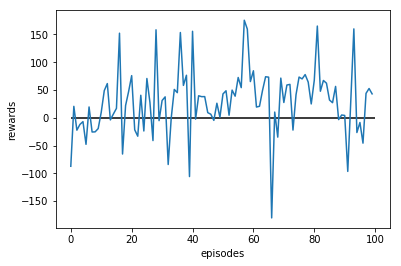

In [6]:
plt.plot(reward_list)
plt.hlines(0,0,100)
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()